In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define o modelo autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        return x

In [ ]:
# Define o conjunto de dados (exemplo)
data = np.random.normal(loc=0, scale=1, size=(1000, 10))
anomaly_data = np.random.normal(loc=5, scale=2, size=(50, 10))
data = np.concatenate((data, anomaly_data), axis=0)

# Separa os dados em treino, validação e teste
train_data = data[:800]
val_data = data[800:900]
test_data = data[900:]

In [ ]:
# Normaliza os dados
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std
test_data = (test_data - mean) / std

In [ ]:
# Define os hiperparâmetros
input_dim = train_data.shape[1]
encoding_dim = 5
lr = 0.001
epochs = 100

In [ ]:
# Cria o modelo, a função de custo e o otimizador
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Treina o modelo
save_every = 1
train_losses = []
val_losses = []
for epoch in range(epochs):
    # Treina com o conjunto de treino
    model.train()
    train_loss = 0
    for x in train_data:
        optimizer.zero_grad()
        x_tensor = torch.tensor(x, dtype=torch.float32)
        recon_tensor = model(x_tensor)
        loss = criterion(recon_tensor, x_tensor)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    # Valida com o conjunto de validação
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x in val_data:
            x_tensor = torch.tensor(x, dtype=torch.float32)
            recon_tensor = model(x_tensor)
            loss = criterion(recon_tensor, x_tensor)
            val_loss += loss.item()
        val_loss /= len(val_data)
        val_losses.append(val_loss)

    if (epoch + 1) % save_every == 0:
        torch.save(model.state_dict(),'/content/drive/MyDrive/Saves/model_epoch_{}.pt'.format(epoch + 1))

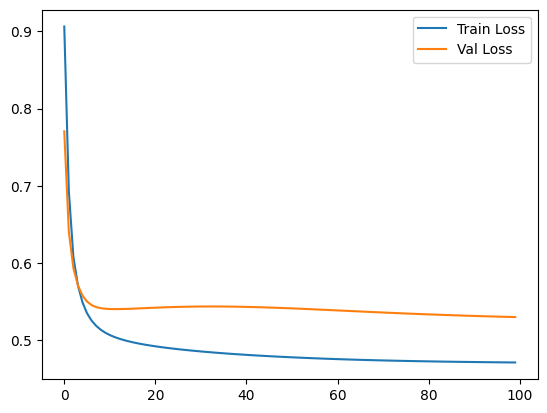

In [ ]:
# Plota os gráficos de erro de treino e validação
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [ ]:
# Escolhe o modelo com o menor erro de validação
best_epoch = np.argmin(val_losses)
model.load_state_dict(torch.load('/content/drive/MyDrive/Saves/model_epoch_{}.pt'.format(best_epoch)))

<All keys matched successfully>

In [ ]:
# Test
model.eval()
test_losses = []
reconstructions = []
with torch.no_grad():
  for x in test_data:
    x_tensor = torch.tensor(x, dtype=torch.float32)
    recon_tensor = model(x_tensor)
    loss = criterion(recon_tensor, x_tensor)
    test_losses.append(loss.item())
    reconstructions.append(recon_tensor.numpy())

test_losses = np.array(test_losses)
reconstructions = np.array(reconstructions)

In [ ]:
# Calcula o limiar de anomalias
mean_loss = np.mean(test_losses)
std_loss = np.std(test_losses)
threshold = mean_loss + 1*std_loss # define um limiar de 1 desvios padrão

In [ ]:
# Identifica anomalias
is_anomaly = test_losses > threshold
predictions = np.where(is_anomaly, 1, 0)
ground_truth = np.concatenate((np.zeros(len(test_data)-50), np.ones(50))) # assume que as últimas 50 amostras são anomalias

In [ ]:
# Calcula as métricas
tn, fp, fn, tp = confusion_matrix(ground_truth, predictions).ravel()
f1_no_anomaly = f1_score(ground_truth, predictions, pos_label=0)
f1_anomaly = f1_score(ground_truth, predictions)
mcc = matthews_corrcoef(ground_truth, predictions)

print(f"Taxa de acerto para não anomalias: {(tn/(tn+fp))*100:.2f}%")
print(f"Taxa de acerto para anomalias: {(tp/(tp+fn))*100:.2f}%")
print(f"F1-score para não anomalias: {f1_no_anomaly:.4f}")
print(f"F1-score para anomalias: {f1_anomaly:.4f}")
print(f"Matthews correlation coefficient: {mcc:.4f}")

Taxa de acerto para não anomalias: 100.00%
Taxa de acerto para anomalias: 66.00%
F1-score para não anomalias: 0.9217
F1-score para anomalias: 0.7952
Matthews correlation coefficient: 0.7511
